# Seperating stock to forcast for certain dates depending on the product

In [35]:
%pip install nbformat


[notice] A new release of pip is available: 24.1.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [37]:
# # import datasets and transformations (reusability purposes)
# from IPython import get_ipython

# get_ipython().run_line_magic('run', 'datasets.ipynb')

In [38]:
import sys
sys.path.append('../src')

In [39]:
from data_config import ProductHandler as ph

In [40]:
ph.custom_prod_set()

All custom codes for existing products: 
{'192', 'ARO', '395', 'PER', '817', '10S', '80V', 'R-0', 'Z-3', '23T', '07W', '45R', '428', '592', 'LC-', 'N-0', 'SPW', '459', '248', '76Z', '084', '34U', 'LS-', 'MOM', '841', 'SMS', 'CRW', 'DPI', 'GJH', '38U', '205', '76T', '69X', '872', '56U', '18V', 'RAV', '384', '082', '454', '77V', '320', '20-', 'WSE', '72X', 'UG-', '15W', '525', 'UJP', '614', '46W', '747', '919', '074', '086', '460', 'FR-', '39R', '04X', '12Q', 'WOE', '951', '-01', '24U', '141', '845', 'SA-', 'AM-', '10X', '681', 'MON', '061', '20Z', '57W', 'PW-', 'LE-', '02S', '53T', 'QU-', 'NAF', '597', 'VR-', '10W', '6X-', 'AFS', 'MW-', '435', '60Y', '518', 'PRA', '663', '010', 'HL-', '561', '11T', 'WL-', '426', 'JF-', '45S', '53V', '724', '546', 'G-0', '16W', '23U', '07X', '839', '386', 'SSW', '32-', '346', 'W-P', '43W', 'MU-', 'ITW', 'MEY', '-03', '90X', '381', '78X', '768', '749', '60X', '383', '372', '60W', '193', '49X', '48V', '3Z-', '204', '926', '311', 'URB', '20X', '170', '517',

In [41]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# define the features and target variable from 'product_sales'
# CHANGE THE CUSTOMER CODE HERE >>>>>>>>>>
custom_code_df = pd.DataFrame(ph.get_custom_code_data('ALB'))

# customer code for later referencing
custom_ref = custom_code_df.loc[0, 'ProductNumber'][:3].lower().upper()
print(custom_ref)

custom_code_df.head()

ALB


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,ALB-005-0022Y,2024,9,39,0,0,191.0,160000,110031.53337,110031.53337,...,160000.000000,160000.000000,160000.000000,160000.000000,0,0,160000,NaN,inf,8000
1,ALB-005-0022Z,2024,7,30,1,0,191.0,96000,110031.53337,110031.53337,...,96000.000000,96000.000000,96000.000000,96000.000000,0,0,96000,NaN,inf,0
2,ALB-005-0023Y,2024,11,45,1,0,191.0,72000,88000.00000,88000.00000,...,57333.333333,57333.333333,57333.333333,57333.333333,0,0,72000,NaN,inf,8000
3,ALB-005-0023Y,2024,12,1,0,0,191.0,12000,110031.53337,110031.53337,...,12000.000000,12000.000000,12000.000000,12000.000000,0,0,12000,NaN,inf,8000
4,ALB-005-0023Y,2024,12,49,3,0,191.0,88000,12000.00000,12000.00000,...,50000.000000,50000.000000,50000.000000,50000.000000,0,0,88000,NaN,inf,8000


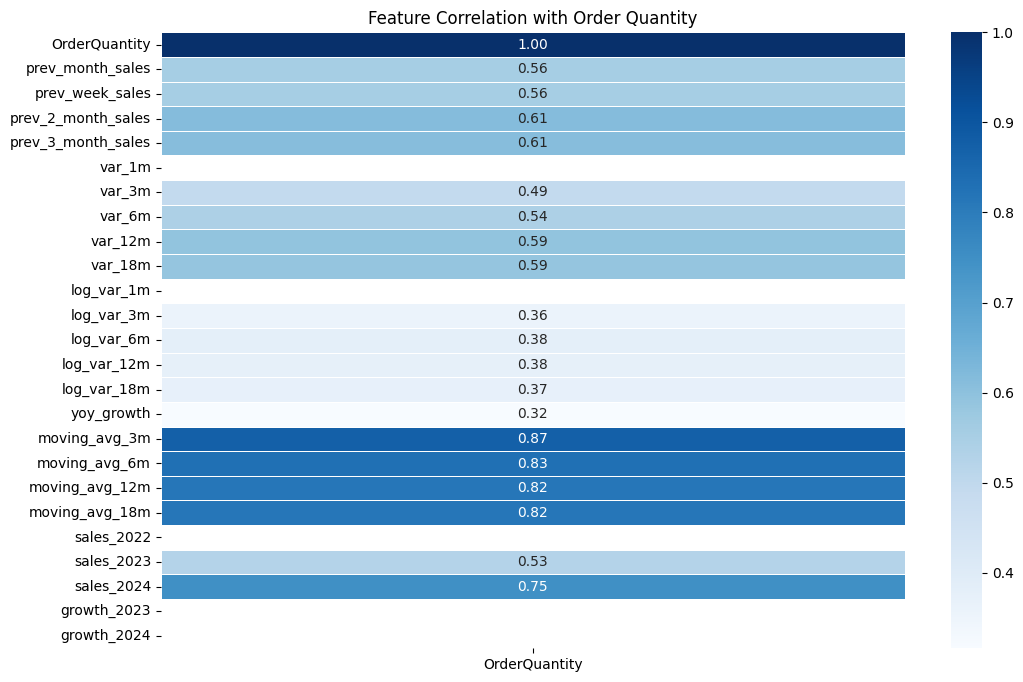

In [42]:
ph.feature_importance(custom_code_df)

In [43]:
from scipy import stats

# Define a function to compute z-scores within each product group
def compute_zscore(group, threshold=3):
    # Only compute z-score if there are at least 2 data points in the group
    if len(group) >= 2:
        group['z_score'] = np.abs(stats.zscore(group['OrderQuantity']))
    else:
        group['z_score'] = 0  # or np.nan if preferred
    return group

# Group by "ProductNumber" and compute z-scores for "OrderQuantity" within each group
df_grouped = custom_code_df.groupby('ProductNumber').apply(compute_zscore)

# Define your threshold for what constitutes an "unusually high" order
z_threshold = 3

# Filter for outliers (orders with a z_score greater than the threshold)
df_outliers = df_grouped[df_grouped['z_score'] > z_threshold]

# Display the results
print("Unusually high order quantities (per ProductNumber):")
print(df_outliers[['ProductNumber', 'OrderQuantity', 'z_score']])

print(f'Dropping: \n{df_outliers.count()}')
# Keep only rows where the z-score is within the acceptable range
df_cleaned = df_grouped[df_grouped['z_score'] <= z_threshold].drop(columns=['z_score'])

# Reset index for clarity
df_cleaned.reset_index(drop=True, inplace=True)

custom_code_df = df_cleaned


Unusually high order quantities (per ProductNumber):
                    ProductNumber  OrderQuantity   z_score
ProductNumber                                             
ALB-026-0003Y 355   ALB-026-0003Y         600000  3.001544
              3363  ALB-026-0003Y         600000  3.001544
ALB-026-0023Z 782   ALB-026-0023Z         250000  3.403706
              3790  ALB-026-0023Z         250000  3.403706
ALB-026-0031Z 974   ALB-026-0031Z         325000  3.330787
              3982  ALB-026-0031Z         325000  3.330787
ALB-026-0035Z 1053  ALB-026-0035Z         260000  3.301515
              4061  ALB-026-0035Z         260000  3.301515
ALB-026-0045Z 1205  ALB-026-0045Z         450000  3.417772
              4213  ALB-026-0045Z         450000  3.417772
ALB-026-0050Z 1264  ALB-026-0050Z         100000  3.072655
              4272  ALB-026-0050Z         100000  3.072655
ALB-026-0063Z 1434  ALB-026-0063Z         280000  3.069565
              4442  ALB-026-0063Z         280000  3.069565
ALB

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_27206/1363007664.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_grouped = custom_code_df.groupby('ProductNumber').apply(compute_zscore)


In [44]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
df = custom_code_df

features = ['ProductNumber', 'order_month',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
            ]
target = 'OrderQuantity'

X = df[features]
y = df[target]

# one-hot encoding for categorical features
categorical_features = ['ProductNumber']
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# preprocessor (keeps numerical features as is)
preprocessor = ColumnTransformer(
    transformers=[
        # one-hot encode categorical features
        ('cat', encoder, categorical_features)
    ], remainder='passthrough'
)

# transform the features
X_transformed = preprocessor.fit_transform(X)


In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [46]:
customer_total = df.copy()

# define features and target
features = ['ProductNumber', 'order_month', 'order_week', 'order_weekday',
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
total_X = customer_total[features]  # Features from top products
total_y = customer_total[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
total_X_train, total_X_val, total_y_train, total_y_val = train_test_split(total_X, total_y, test_size=0.2, random_state=42)

# Transform the features
total_X_train_transformed = preprocessor.fit_transform(total_X_train)
total_X_val_transformed = preprocessor.transform(total_X_val)

# Output the shape
print(f"Train Shape: {total_X_train_transformed.shape}, Validation Shape: {total_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")

customer_total.head()


Train Shape: (4560, 337), Validation Shape: (1140, 337)
Feature processing for top products completed successfully!


,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_3m,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv
0,ALB-005-0023Y,2024,11,45,1,0,191.0,72000,88000.00000,88000.00000,...,57333.333333,57333.333333,57333.333333,57333.333333,0,0,72000,NaN,inf,8000
1,ALB-005-0023Y,2024,12,1,0,0,191.0,12000,110031.53337,110031.53337,...,12000.000000,12000.000000,12000.000000,12000.000000,0,0,12000,NaN,inf,8000
2,ALB-005-0023Y,2024,12,49,3,0,191.0,88000,12000.00000,12000.00000,...,50000.000000,50000.000000,50000.000000,50000.000000,0,0,88000,NaN,inf,8000
3,ALB-005-0023Y,2024,11,45,1,0,191.0,72000,88000.00000,88000.00000,...,57333.333333,57333.333333,57333.333333,57333.333333,0,0,72000,NaN,inf,8000
4,ALB-005-0023Y,2024,12,1,0,0,191.0,12000,110031.53337,110031.53337,...,12000.000000,12000.000000,12000.000000,12000.000000,0,0,12000,NaN,inf,8000


In [47]:
# the top 10 (or change) products by total actual order quantity
top_products = df.groupby('ProductNumber')['OrderQuantity'].sum().nlargest(1)

# extract top product code rows from the original df
top_prods_df = df[df['ProductNumber'].isin(top_products.index)]

# Extract top product numbers
top_product_numbers = top_products.index.tolist()  # List of top product numbers

top_prods_df.head()

unique_order_years = custom_code_df['order_year'].unique()
print(unique_order_years)

[2024 2025 2023]


In [48]:
# define features and target
features = ['ProductNumber', 'order_month', 
            'prev_month_sales', 'prev_week_sales', 'prev_2_month_sales', 'prev_3_month_sales',
            'moving_avg_3m', 'moving_avg_6m', 'moving_avg_12m', 'moving_avg_18m',
            'var_3m', 'var_6m', 'var_12m', 'var_18m',
            'log_var_3m', 'log_var_6m', 'log_var_12m', 'log_var_18m',
            'yoy_growth', 'sales_2023', 'sales_2024'
           ]
target = 'OrderQuantity'

# filter the top products
tp_X = top_prods_df[features]  # Features from top products
tp_y = top_prods_df[target]    # Target variable

# define categorical and numeric features
categorical_features = ['ProductNumber']
numeric_features = list(set(features) - set(categorical_features))  # All other features are numeric

# Define transformations
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
scaler = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),   # One-hot encode categorical features
        ('num', scaler, numeric_features)        # Standardize numeric features
    ]
)

# Train-test split
tp_X_train, tp_X_val, tp_y_train, tp_y_val = train_test_split(tp_X, tp_y, test_size=0.2, random_state=42)

# Transform the features
tp_X_train_transformed = preprocessor.fit_transform(tp_X_train)
tp_X_val_transformed = preprocessor.transform(tp_X_val)

# Output the shape
print(f"Train Shape: {tp_X_train_transformed.shape}, Validation Shape: {tp_X_val_transformed.shape}")
print("Feature processing for top products completed successfully!")


Train Shape: (49, 21), Validation Shape: (13, 21)
Feature processing for top products completed successfully!


In [49]:
from sklearn.ensemble import RandomForestRegressor
from model_utils import find_best_hyperparameters, param_grids, evaluate_model

In [50]:
# train the model with scaled features (Random Forest Regressor)
rf = RandomForestRegressor()
rf_params = find_best_hyperparameters(rf, param_grids(rf.__class__.__name__), X_train_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, 

In [51]:
rf = RandomForestRegressor(**rf_params)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

In [52]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(rf, X_train_scaled, y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(rf, X_val_scaled, y_val)
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 6582.9533
Mean Squared Error (MSE): 1308380660.0621
Root Mean Squared Error (RMSE): 36171.5449
R-squared (R²): 0.9827
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 16750.7877
Mean Squared Error (MSE): 7046627513.6220
Root Mean Squared Error (RMSE): 83944.1929
R-squared (R²): 0.8882
--------------------------------------------


In [53]:
# train the model with scaled features (Random Forest Regressor) - TOTAL CUSTOM PRODUCTS IMPLEMENTATION
total_rf = RandomForestRegressor()
total_rf_params = find_best_hyperparameters(total_rf, param_grids(total_rf.__class__.__name__), total_X_train_transformed, total_y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.4s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, 

In [54]:
total_rf = RandomForestRegressor(**total_rf_params)
total_rf.fit(total_X_train_transformed, total_y_train)
total_y_pred_rf = total_rf.predict(total_X_val_transformed)

In [55]:
print('---------------------- TRAINING PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_train_transformed, total_y_train)
print('--------------------------------------------')

print('---------------------- TEST PERFORMANCE ----------------------')
evaluate_model(total_rf, total_X_val_transformed, total_y_val)
print('--------------------------------------------')

---------------------- TRAINING PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 6413.3821
Mean Squared Error (MSE): 1197967758.0803
Root Mean Squared Error (RMSE): 34611.6708
R-squared (R²): 0.9841
--------------------------------------------
---------------------- TEST PERFORMANCE ----------------------
Evaluating model...
Model: RandomForestRegressor
Mean Absolute Error (MAE): 17435.7421
Mean Squared Error (MSE): 7367072201.1772
Root Mean Squared Error (RMSE): 85831.6503
R-squared (R²): 0.8831
--------------------------------------------


[99739.21074572194, 19997.23680273723, 25000.01298701299, 55020.0, 60000.0, 105075.0, 2521700.0, 330025.0, 308425.0, 19998.5, 1084975.0, 89840.0, 224364.34782608695, 24703.0, 45794.35, 60000.0, 107865.0, 25000.01298701299, 45025.0, 270340.0, 89850.0, 536500.0, 25650.216690716694, 15406.293260473589, 30050.0, 30000.0, 21327.5, 71980.0, 50000.0, 176545.0, 100000.0, 263663.0263157895, 19997.793805209094, 16565.310344827583, 127960.0, 25001.01298701299, 49851.0752688172, 240226.4705882353, 79925.0, 120078.35317460317, 1199975.0, 69333.0, 25188.0, 254046.7763157895, 33290.34506540859, 20000.0, 19099.063273325468, 25200.0, 20126.563273325464, 273170.0, 49696.32915360501, 50000.0, 51950.0, 63772.0, 50167.70833333334, 93442.67261904762, 16419.825968874713, 14947.665673725474, 30000.0, 564675.0, 60000.0, 71962.12121212122, 406875.0, 99150.0, 25000.01298701299, 50000.0, 89420.0, 20000.0, 69992.5, 922475.0, 15016.49094887878, 198650.0, 120000.0, 90000.0, 30000.0, 30000.0, 144039.56831119544, 6402

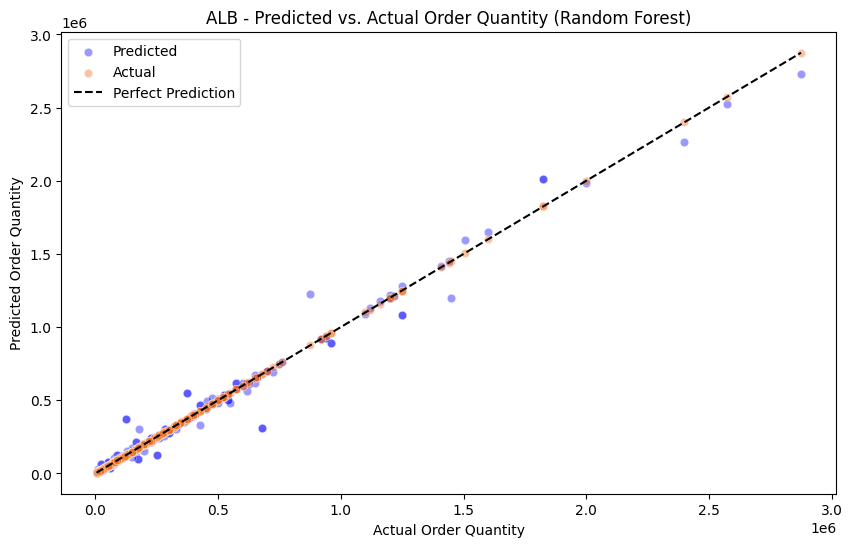

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_pred_rf.tolist())

plt.figure(figsize=(10, 6))

# scatter plot, actual vs predicted values
sns.scatterplot(x=y_val, y=y_pred_rf, alpha=0.4, color='blue', label='Predicted')  # Predicted values in blue

# actual values in red
sns.scatterplot(x=y_val, y=y_val, alpha=0.4, color='#f26d1d', label='Actual')

# reference line for perfect prediction
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], '--', color='black', label="Perfect Prediction")

plt.xlabel("Actual Order Quantity")
plt.ylabel("Predicted Order Quantity")
plt.title(f"{custom_ref} - Predicted vs. Actual Order Quantity (Random Forest)")
plt.legend()

plt.show()

/var/folders/31/9bd8ksys1rzbjk8qs9scl95h0000gn/T/ipykernel_27206/1606837329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))


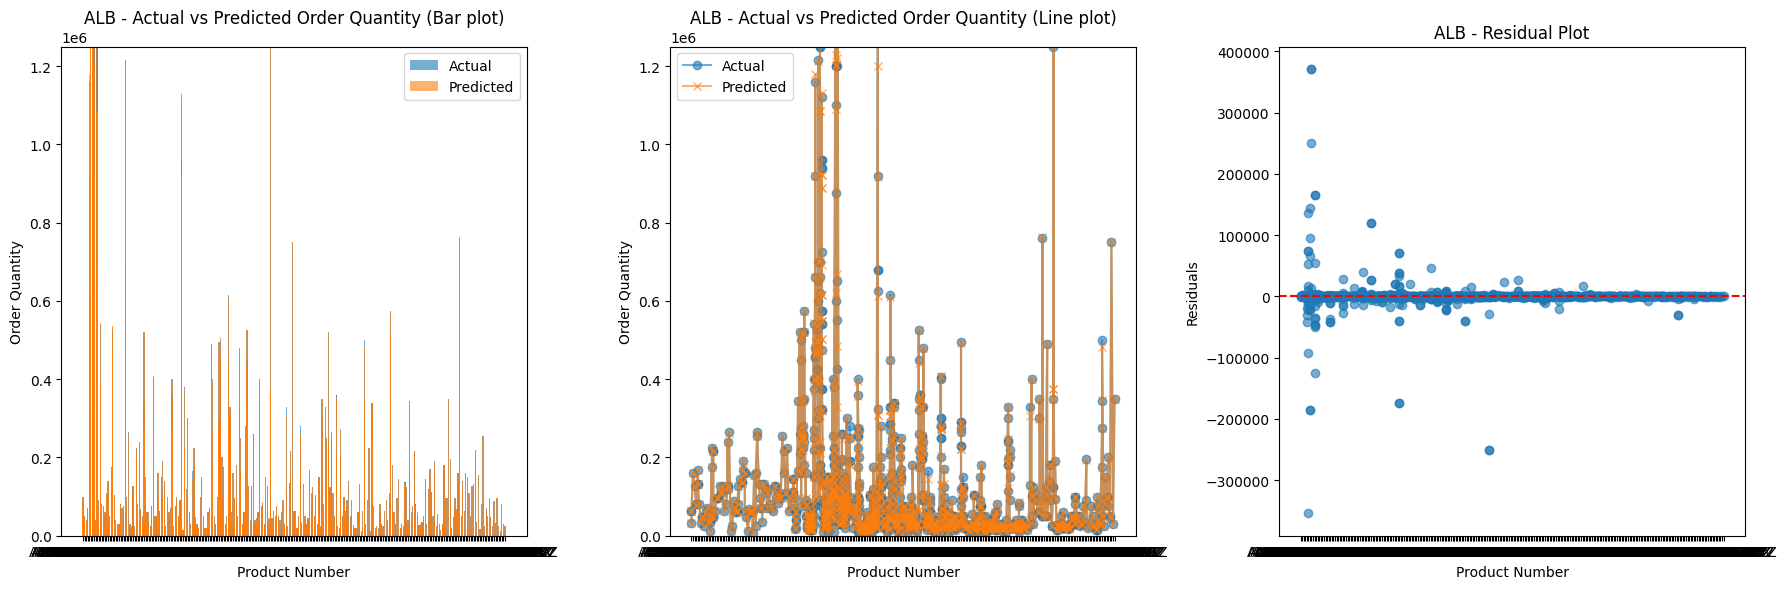

In [57]:
# Convert order year and month to datetime format
top_prods_df['OrderDate'] = pd.to_datetime(top_prods_df[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
top_prods_df = top_prods_df.sort_values(by='OrderDate')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_val, label='Actual', alpha=0.6)
axes[0].bar(df.loc[y_val.index, 'ProductNumber'], y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Product Number')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Bar plot)')
axes[0].set_ylim(0, 1250000)
axes[0].legend()

# Line plot, actual and predicted values
sorted_indices = df.loc[y_val.index, 'ProductNumber'].argsort()
sorted_products = df.loc[y_val.index, 'ProductNumber'].iloc[sorted_indices]
sorted_actual = y_val.iloc[sorted_indices]
sorted_predicted = y_pred_rf[sorted_indices]

axes[1].plot(sorted_products, sorted_actual, label='Actual', alpha=0.6, marker='o')
axes[1].plot(sorted_products, sorted_predicted, label='Predicted', alpha=0.6, marker='x')
axes[1].set_xlabel('Product Number')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity (Line plot)')
axes[1].set_ylim(0, 1250000)
axes[1].legend()

# Residual plot
residuals = y_val - y_pred_rf
axes[2].scatter(df.loc[y_val.index, 'ProductNumber'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Product Number')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot')

plt.tight_layout()
plt.show()


In [58]:
# Convert order year and month to datetime format
customer_total['OrderDate'] = pd.to_datetime(customer_total[['order_year', 'order_month']].astype(str).agg('-'.join, axis=1))

# Sort by OrderDate to maintain time order
customer_total = customer_total.sort_values(by='OrderDate')

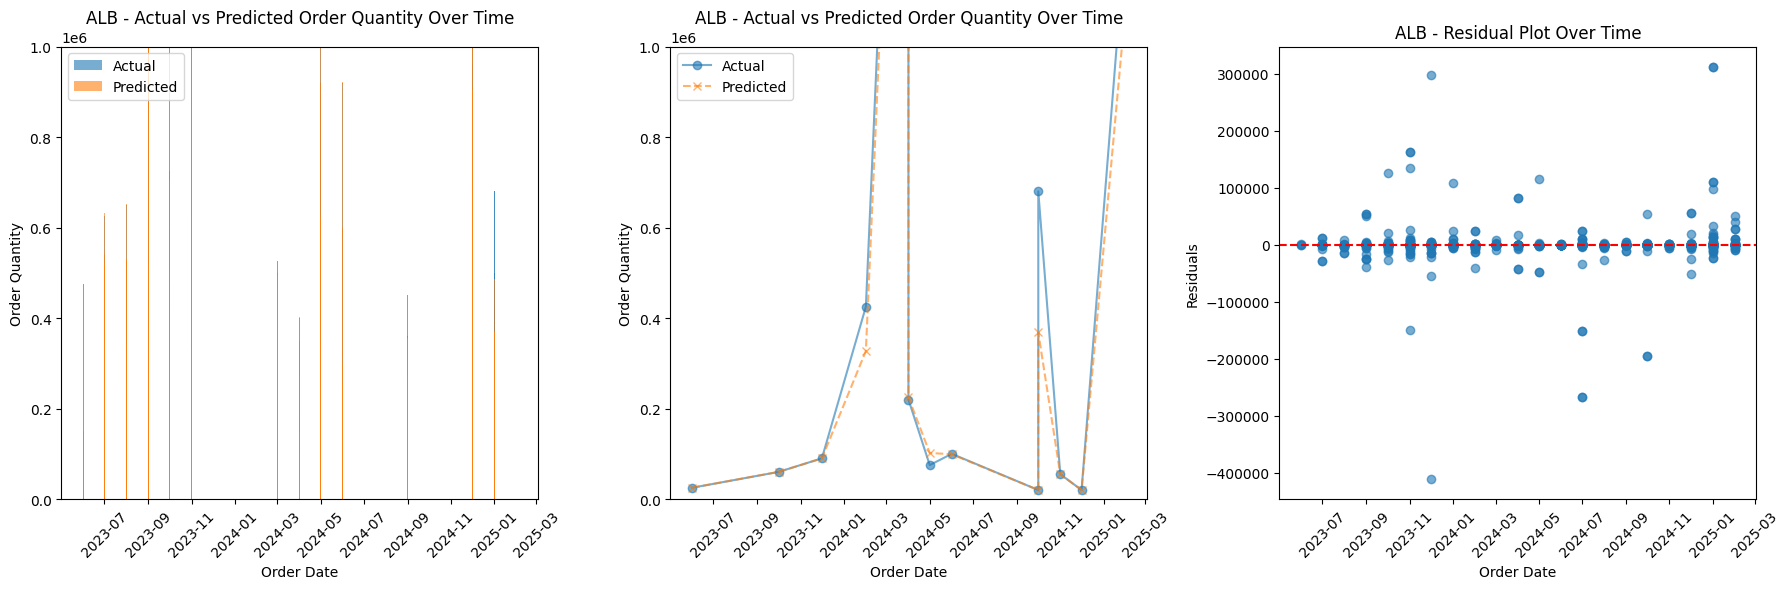

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Bar plot, actual and predicted values over time
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0].set_xlabel('Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[0].set_ylim(0, 2000000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Line plot, actual and predicted values over time
sorted_indices = top_prods_df.loc[tp_y_val.index, 'OrderDate'].argsort()
sorted_dates = top_prods_df.loc[tp_y_val.index, 'OrderDate'].iloc[sorted_indices]
sorted_actual = total_y_val.iloc[sorted_indices]
sorted_predicted = total_y_pred_rf[sorted_indices]

axes[1].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[1].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[1].set_xlabel('Order Date')
axes[1].set_ylabel('Order Quantity')
axes[1].set_title(f'{custom_ref} - Actual vs Predicted Order Quantity Over Time')
axes[1].set_ylim(0, 2000000)
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)

# Residual plot over time
residuals = total_y_val - total_y_pred_rf
axes[2].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Order Date')
axes[2].set_ylabel('Residuals')
axes[2].set_title(f'{custom_ref} - Residual Plot Over Time')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [60]:
# # to see dataframe structure
# customer_total.head()


In [61]:
# # to see prediction nparray structure
# total_y_pred_rf

In [62]:
# # Group data by OrderDate and sum the relevant numerical columns
# customer_total = top_prods_df.groupby('OrderDate').sum(numeric_only=True).reset_index()

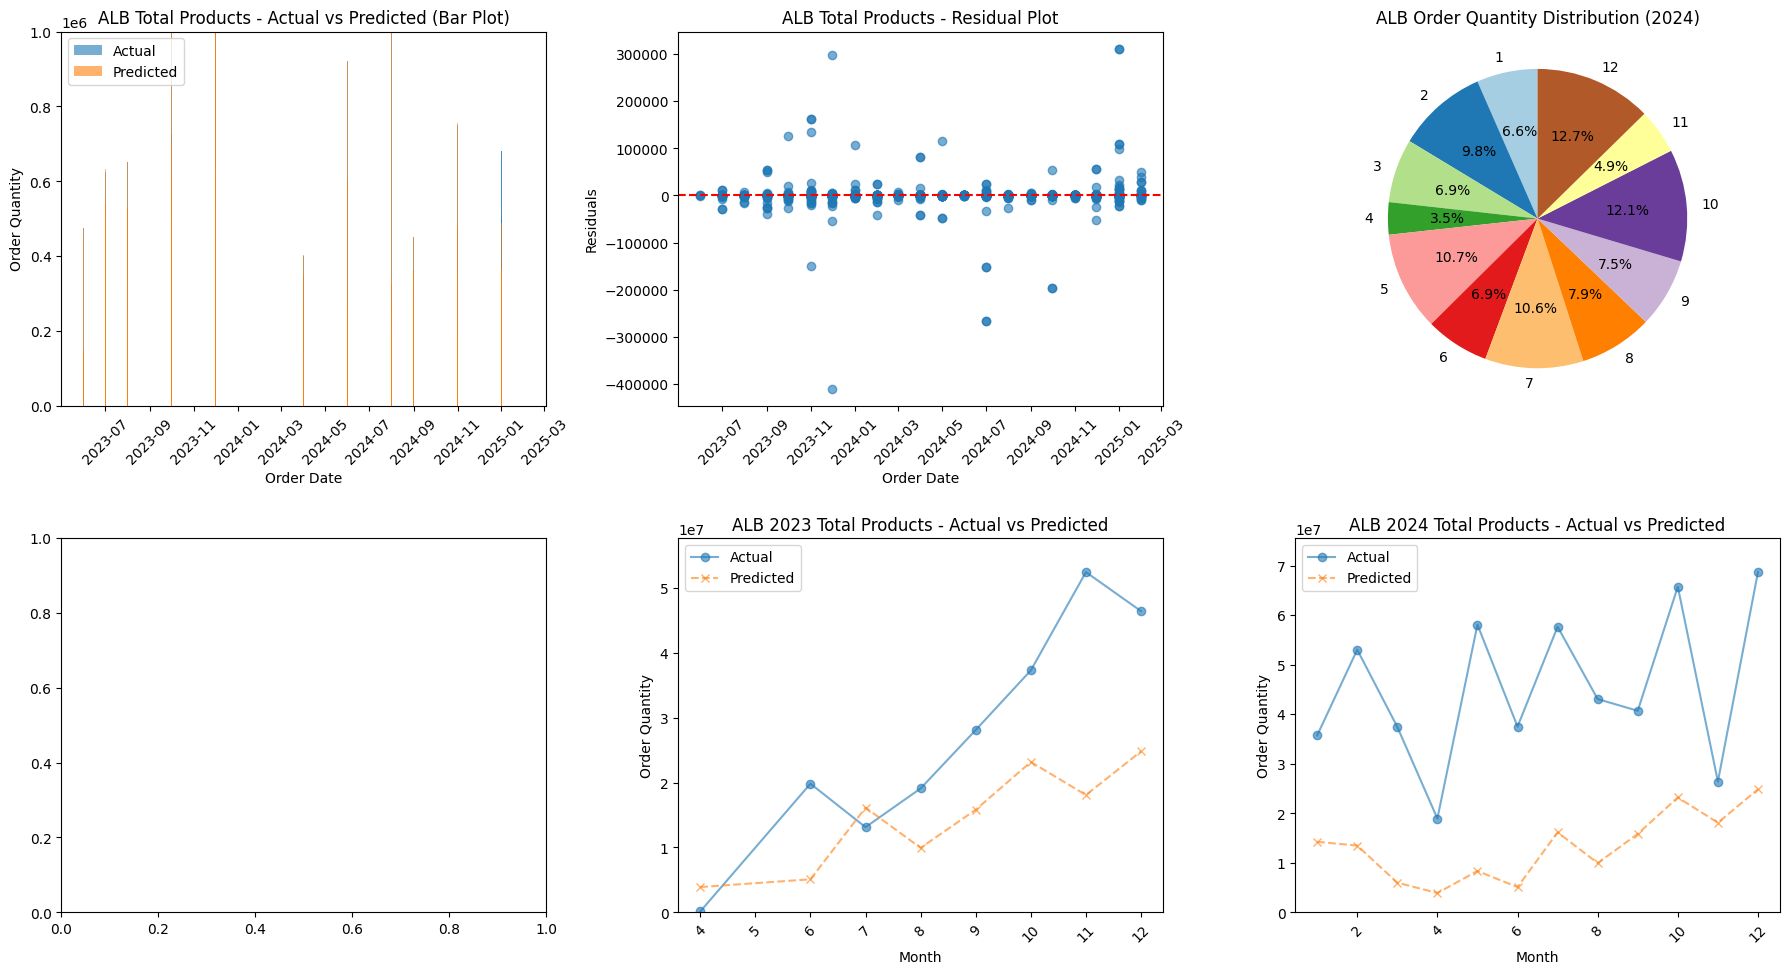

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust layout for better spacing

# Bar plot: Actual vs. Predicted Order Quantity
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_val, label='Actual', alpha=0.6)
axes[0, 0].bar(customer_total.loc[total_y_val.index, 'OrderDate'], total_y_pred_rf, label='Predicted', alpha=0.6)
axes[0, 0].set_xlabel('Order Date')
axes[0, 0].set_ylabel('Order Quantity')
axes[0, 0].set_title(f'{custom_ref} Total Products - Actual vs Predicted (Bar Plot)')
axes[0, 0].set_ylim(0, 1_000_000)
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# Residual Plot
residuals = total_y_val - total_y_pred_rf
axes[0, 1].scatter(customer_total.loc[total_y_val.index, 'OrderDate'], residuals, alpha=0.6)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Order Date')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title(f'{custom_ref} Total Products - Residual Plot')
axes[0, 1].tick_params(axis='x', rotation=45)

# Pie Chart: Order Quantity per Month (2024)
order_2024 = customer_total[customer_total['order_year'] == 2024].groupby('order_month')['OrderQuantity'].sum()
axes[0, 2].pie(order_2024, labels=order_2024.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0, 2].set_title(f'{custom_ref} Order Quantity Distribution (2024)')

# Line Plots: Yearly Trends
for i, year in enumerate([2022, 2023, 2024]):  
    yearly_df = customer_total[customer_total['order_year'] == year]

    if yearly_df.empty:
        continue  # skip if no data for that year

    # Aggregate OrderQuantity per month
    monthly_actual = yearly_df.groupby('order_month')['OrderQuantity'].sum()

    # Convert total_y_pred_rf to Pandas Series with index from customer_total
    pred_series = pd.Series(total_y_pred_rf, index=total_y_val.index)

    # Group predictions by month
    monthly_predicted = pred_series.groupby(customer_total.loc[total_y_val.index, 'order_month']).sum()

    # Sort for proper plotting
    monthly_actual = monthly_actual.sort_index()
    monthly_predicted = monthly_predicted.reindex(monthly_actual.index)  # Ensure same months

    # Plot actual and predicted values for the year
    axes[1, i].plot(monthly_actual.index, monthly_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
    axes[1, i].plot(monthly_predicted.index, monthly_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')

    axes[1, i].set_xlabel('Month')
    axes[1, i].set_ylabel('Order Quantity')
    axes[1, i].set_title(f'{custom_ref} {year} Total Products - Actual vs Predicted')
    axes[1, i].set_ylim(0, max(monthly_actual.max(), monthly_predicted.max()) * 1.1)  # Scale Y axis
    axes[1, i].legend()
    axes[1, i].tick_params(axis='x', rotation=45)

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [64]:
has_orders_2022 = not customer_total[customer_total['order_year'] == 2022].empty
print(f"Orders in 2022 exist: {has_orders_2022}")


Orders in 2022 exist: False


In [65]:
customer_total.head(10)

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
482,ALB-026-0001Z,2023,4,14,4,0,191.0,60000,60000.0,60000.0,...,5.000000e+04,5.333333e+04,5.285714e+04,0,60000,0,inf,-100.0,15000,2023-04-01
496,ALB-026-0001Z,2023,4,14,4,0,191.0,60000,60000.0,60000.0,...,5.000000e+04,5.333333e+04,5.285714e+04,0,60000,0,inf,-100.0,15000,2023-04-01
1173,ALB-026-0019Y,2023,6,24,4,0,191.0,475000,375000.0,375000.0,...,3.708333e+05,5.025000e+05,5.697222e+05,0,475000,0,inf,-100.0,50000,2023-06-01
968,ALB-026-0016Y,2023,6,24,4,0,191.0,1300000,525000.0,525000.0,...,5.250000e+05,5.395833e+05,6.808333e+05,0,1300000,0,inf,-100.0,205000,2023-06-01
1334,ALB-026-0023Z,2023,6,25,0,0,191.0,150000,60000.0,60000.0,...,7.250000e+04,7.083333e+04,7.638889e+04,0,150000,0,inf,-100.0,95000,2023-06-01
1388,ALB-026-0024Z,2023,6,25,0,0,191.0,140000,135000.0,135000.0,...,8.500000e+04,8.166667e+04,7.888889e+04,0,140000,0,inf,-100.0,5000,2023-06-01
1532,ALB-026-0027Z,2023,6,25,0,0,191.0,350000,100000.0,100000.0,...,1.425000e+05,1.425000e+05,1.533333e+05,0,350000,0,inf,-100.0,40000,2023-06-01
1646,ALB-026-0029Z,2023,6,25,0,0,191.0,2800000,650000.0,650000.0,...,1.101667e+06,1.657500e+06,1.565278e+06,0,2800000,0,inf,-100.0,65000,2023-06-01
1668,ALB-026-0029Z,2023,6,25,0,0,191.0,2800000,650000.0,650000.0,...,1.101667e+06,1.657500e+06,1.565278e+06,0,2800000,0,inf,-100.0,65000,2023-06-01
938,ALB-026-0015Y,2023,6,24,4,0,191.0,1225000,525000.0,525000.0,...,5.658333e+05,5.441667e+05,6.330556e+05,0,1225000,0,inf,-100.0,460000,2023-06-01


In [66]:
# from powerbiclient import QuickVisualize, get_dataset_config, Report
# from powerbiclient.authentication import InteractiveLoginAuthentication, DeviceCodeLoginAuthentication
# import pandas as pd

# prod_sales = pd.read_csv(
#     '/Users/mwilko777/Desktop/Project/Software Artifact/datasets/stock_forecasting/final/product_sales.csv')

# # use DeviceCodeLoginAuthentication if want to sign in each time, else InteractiveLoginAuthentication
# auth = InteractiveLoginAuthentication()
# print("Authentication successful.")


# def visual():
#     dataset_config = get_dataset_config(prod_sales)
#     return QuickVisualize(dataset_config, auth)

# visual()

In [67]:
customer_total.head()

,ProductNumber,order_year,order_month,order_week,order_weekday,is_weekend,Customer_Num,OrderQuantity,prev_month_sales,prev_week_sales,...,moving_avg_6m,moving_avg_12m,moving_avg_18m,sales_2022,sales_2023,sales_2024,growth_2023,growth_2024,PhysicalInv,OrderDate
482,ALB-026-0001Z,2023,4,14,4,0,191.0,60000,60000.0,60000.0,...,50000.000000,53333.333333,52857.142857,0,60000,0,inf,-100.0,15000,2023-04-01
496,ALB-026-0001Z,2023,4,14,4,0,191.0,60000,60000.0,60000.0,...,50000.000000,53333.333333,52857.142857,0,60000,0,inf,-100.0,15000,2023-04-01
1173,ALB-026-0019Y,2023,6,24,4,0,191.0,475000,375000.0,375000.0,...,370833.333333,502500.000000,569722.222222,0,475000,0,inf,-100.0,50000,2023-06-01
968,ALB-026-0016Y,2023,6,24,4,0,191.0,1300000,525000.0,525000.0,...,525000.000000,539583.333333,680833.333333,0,1300000,0,inf,-100.0,205000,2023-06-01
1334,ALB-026-0023Z,2023,6,25,0,0,191.0,150000,60000.0,60000.0,...,72500.000000,70833.333333,76388.888889,0,150000,0,inf,-100.0,95000,2023-06-01


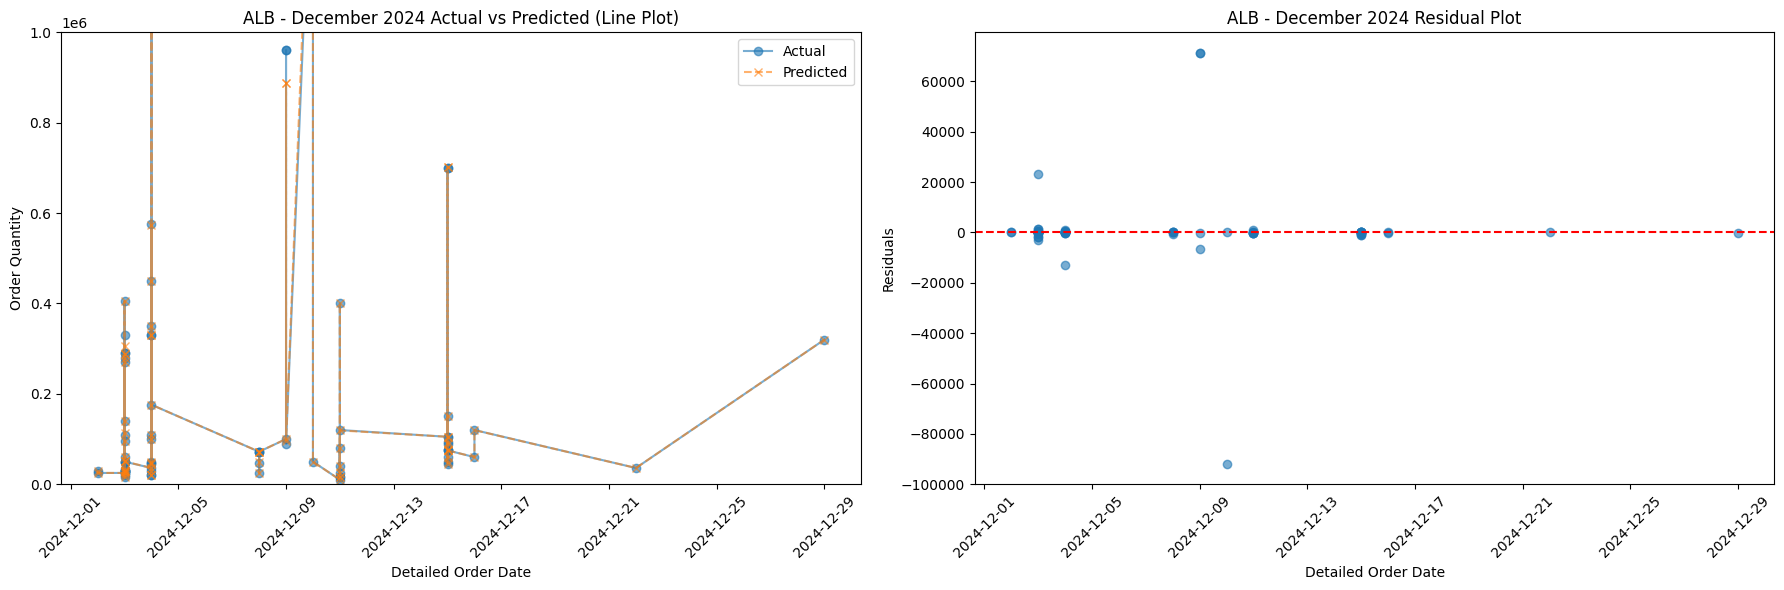

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Create a DetailedOrderDate column using week and weekday information.
# Adjust the format as needed based on your data.
customer_total['DetailedOrderDate'] = pd.to_datetime(
    customer_total['order_year'].astype(str) +
    customer_total['order_week'].astype(str).str.zfill(2) +
    customer_total['order_weekday'].astype(str),
    format='%Y%W%w'
)

# Filter the data for December 2024 using DetailedOrderDate
dec_2024_data = customer_total[
    (customer_total['DetailedOrderDate'].dt.year == 2024) &
    (customer_total['DetailedOrderDate'].dt.month == 12)
]

# Use only the common indices between dec_2024_data and y_val
common_index = dec_2024_data.index.intersection(y_val.index)
dec_2024_actual = y_val.loc[common_index]
# Convert y_pred_rf to a Series for indexing (using the same index as y_val)
y_pred_rf_series = pd.Series(y_pred_rf, index=y_val.index)
dec_2024_predicted = y_pred_rf_series.loc[common_index]

# --- Incorporate your provided sorting snippet, adapted for December 2024 data ---
# Here we sort by DetailedOrderDate from dec_2024_data for the common indices.
sorted_indices = dec_2024_data.loc[common_index, 'DetailedOrderDate'].argsort()
sorted_dates = dec_2024_data.loc[common_index, 'DetailedOrderDate'].iloc[sorted_indices]
sorted_actual = dec_2024_actual.iloc[sorted_indices]
sorted_predicted = dec_2024_predicted.iloc[sorted_indices]
# --- End of sorting snippet ---

# Create subplots (1 row, 2 columns: one for line plot, one for residual plot)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Line Plot: Actual vs. Predicted Order Quantity using DetailedOrderDate
axes[0].plot(sorted_dates, sorted_actual, label='Actual', alpha=0.6, marker='o', linestyle='-')
axes[0].plot(sorted_dates, sorted_predicted, label='Predicted', alpha=0.6, marker='x', linestyle='--')
axes[0].set_xlabel('Detailed Order Date')
axes[0].set_ylabel('Order Quantity')
axes[0].set_title(f'{custom_ref} - December 2024 Actual vs Predicted (Line Plot)')
axes[0].set_ylim(0, 1_000_000)
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Residual Plot for December 2024
residuals_dec_2024 = sorted_actual - sorted_predicted
axes[1].scatter(sorted_dates, residuals_dec_2024, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Detailed Order Date')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'{custom_ref} - December 2024 Residual Plot')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
